In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score
from torchcrf import CRF
from utils import get_sequences, GetLabels, My_Pad_Input

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [3]:
torch.cuda.set_device(1)

In [4]:
OUT_DIM=12
INPUT_DIM=128
BS= 64

In [5]:
train = pd.read_csv("./data/train_fusion.csv")
val = pd.read_csv("./data/val_fusion.csv")
test_data = pd.read_csv("./data/test_fusion.csv")

In [6]:
train["document_type"] = train.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
val["document_type"] = val.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
test_data["document_type"] = test_data.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                   axis=1)

In [7]:
X_train, y_train = get_sequences(train)
X_valid, y_valid = get_sequences(val)
X_test, y_test = get_sequences(test_data)

In [8]:
data = pd.concat([pd.DataFrame({"acts":X_train, "labels":y_train, "is_valid": False}),
                 pd.DataFrame({"acts":X_valid, "labels":y_valid, "is_valid": True})])

In [9]:
class GetFusionActs(Transform):
    def encodes(self, x):    
        acts = []
        for act in x["acts"]:
            acts.append(torch.load(act.replace("text", "fusion") + ".pt").unsqueeze(0)) 
        return torch.cat(acts)

In [10]:
my_pad_input=My_Pad_Input(12)

In [11]:
tfms = [[GetFusionActs()], [GetLabels()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=partial(my_pad_input, pad_fields=[0,1]), bs=BS)

In [12]:
dls.one_batch()

(TensorImage([[[2536.5645, 1202.7659,    0.0000,  ..., 1059.7418, 1346.0215,
           1284.9678],
          [2042.7552, 1041.8928,    0.0000,  ...,  932.9737,  540.0562,
            700.6108],
          [1998.8265,  730.4681,    0.0000,  ...,  541.1230,  247.2102,
            737.4384],
          ...,
          [ 638.9882,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [  46.8504,    0.0000,  129.9425,  ...,    0.0000,    0.0000,
              0.0000],
          [  49.5828,    0.0000,  199.4848,  ...,    0.0000,    0.0000,
              0.0000]],
 
         [[3891.1606, 2027.0656,    0.0000,  ..., 2048.6665, 1601.7617,
           1508.9297],
          [ 568.9702,   52.4873,  128.5337,  ...,   65.1924,  135.0942,
              0.0000],
          [ 437.9700,    0.0000,  137.8719,  ...,    0.0000,    0.0000,
              0.0000],
          ...,
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [ 

In [13]:
torch.save(dls, "./data/dls_sequence_v2.pth")

In [11]:
dls = torch.load("./data/dls_sequence_v2.pth")

In [14]:
class SequenceModel(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128):
        self.lstm = torch.nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop = nn.Dropout().cuda()
        self.lin = nn.Linear(hidden_dim*2, out_dim).cuda()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn(out)
        out_drop = self.drop(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin(out_drop)

In [22]:
model = SequenceModel(128, 12)

In [15]:
def loss_func(out, targ):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM)(out, targ.long())

In [16]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    pred =np.argmax(pred, axis=-1)
    pred, targ = flatten_check(pred, targ)
    pad_idxs = [i for i,x in enumerate(targ) if x != tensor([12])]
    pred = pred[pad_idxs]
    targ = targ[pad_idxs]
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [25]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [26]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 256',  264,192    True      
________________________________________________________________
BatchNorm1d          64 x 256 x 4242      512        True      
________________________________________________________________
Dropout              64 x 256 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       3,084      True      
________________________________________________________________

Total params: 267,788
Total trainable params: 267,788
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fd07c9f54c0>
Loss function: <function loss_func at 0x7fd06753a5e0>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

In [27]:
learn.validate()

(#2) [2.5863826274871826,0.049502885806878415]

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.03981071710586548)

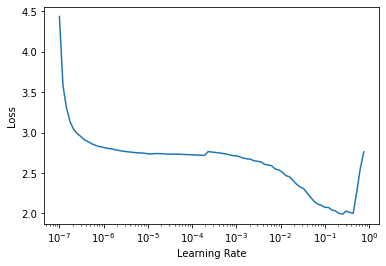

In [28]:
learn.lr_find()

In [29]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,1.961057,1.081553,0.610358,03:36
1,1.051916,0.741459,0.325666,04:25
2,0.778732,0.678201,0.522402,04:16
3,0.650243,0.632359,0.546386,04:31
4,0.595360,0.850648,0.606682,04:12
5,0.529355,0.692955,0.573457,04:01
6,0.571075,1.102272,0.660538,04:18
7,0.534762,0.795043,0.730020,04:10
8,0.477003,0.742114,0.763850,04:11
9,0.437202,0.715917,0.769394,04:07


Better model found at epoch 0 with f1_score value: 0.6103582659377209.


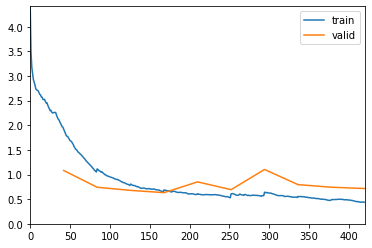

Better model found at epoch 6 with f1_score value: 0.6605381629039412.
Better model found at epoch 7 with f1_score value: 0.7300203646811069.
Better model found at epoch 8 with f1_score value: 0.7638503360387231.
Better model found at epoch 9 with f1_score value: 0.7693939408255023.


In [30]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [31]:
model = SequenceModel(128, 12, hidden_dim=256)

In [32]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [33]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 512',  790,528    True      
________________________________________________________________
BatchNorm1d          64 x 512 x 4242      1,024      True      
________________________________________________________________
Dropout              64 x 512 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       6,156      True      
________________________________________________________________

Total params: 797,708
Total trainable params: 797,708
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fd07c9f54c0>
Loss function: <function loss_func at 0x7fd06753a5e0>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.019054606556892395)

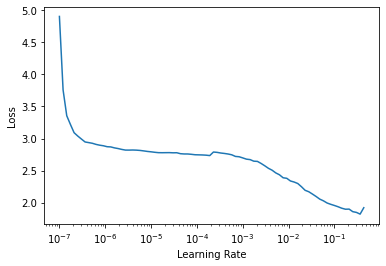

In [34]:
learn.lr_find()

In [35]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_256'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,1.738328,0.706088,0.597457,03:43
1,1.050031,0.635543,0.425321,03:49
2,0.854596,2.389529,0.507217,04:12
3,0.712987,0.630090,0.535214,04:03
4,0.616051,1.110406,0.506089,04:15
5,0.556068,0.670646,0.755296,04:04
6,0.514513,0.671462,0.725564,04:02
7,0.474921,0.686596,0.754778,04:23
8,0.454099,0.659062,0.763931,04:15
9,0.439986,0.660476,0.770568,04:09


Better model found at epoch 0 with f1_score value: 0.5974572802351404.


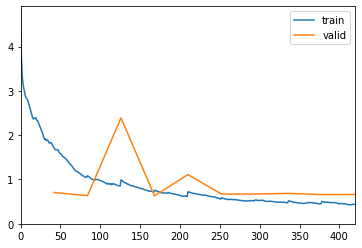

Better model found at epoch 5 with f1_score value: 0.7552957386895588.
Better model found at epoch 8 with f1_score value: 0.7639306937349533.
Better model found at epoch 9 with f1_score value: 0.7705676184137128.


In [36]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [17]:
model = SequenceModel(128, 12, hidden_dim=256)

In [18]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [19]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 512',  790,528    True      
________________________________________________________________
BatchNorm1d          64 x 512 x 4242      1,024      True      
________________________________________________________________
Dropout              64 x 512 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       6,156      True      
________________________________________________________________

Total params: 797,708
Total trainable params: 797,708
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f9d223909d0>
Loss function: <function loss_func at 0x7f9d046e5790>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.033113110810518265)

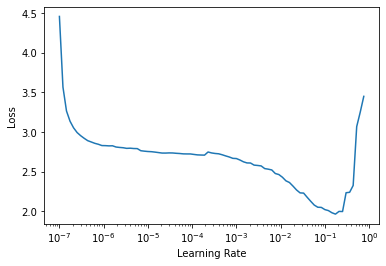

In [20]:
learn.lr_find()

In [21]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_256_more_epochs'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,2.559511,2.005065,0.292069,00:39
1,2.224641,1.308529,0.629570,00:23
2,1.765213,1.007539,0.746578,00:25
3,1.331168,0.854805,0.754534,00:25
4,0.980908,0.682560,0.743382,00:26
5,0.762878,0.590571,0.757214,00:22
6,0.620738,0.814031,0.765041,00:24
7,0.521765,0.713429,0.776831,00:24
8,0.449292,0.566135,0.770195,00:25
9,0.386741,0.572669,0.770818,00:23


Better model found at epoch 0 with f1_score value: 0.29206851293027164.


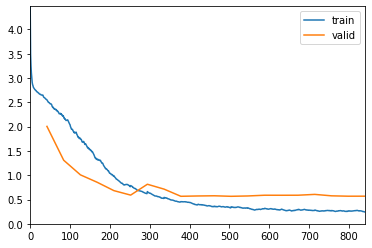

Better model found at epoch 1 with f1_score value: 0.6295698302036681.
Better model found at epoch 2 with f1_score value: 0.7465781594349497.
Better model found at epoch 3 with f1_score value: 0.7545342294481568.
Better model found at epoch 5 with f1_score value: 0.7572137640960674.
Better model found at epoch 6 with f1_score value: 0.765041436715482.
Better model found at epoch 7 with f1_score value: 0.7768308508750338.


In [22]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [23]:
learn.load("best_sequence_256_more_epochs")

In [24]:
def evaluate(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
    targets = [x for sublist in targets for x in sublist]
    pad_idxs = [i for i,x in enumerate(targets) if x != tensor([12])]
    preds = L(preds)[pad_idxs]
    targets = L(targets)[pad_idxs]
    print(classification_report(targets, preds, target_names=dl.get_labels.cat.vocab, digits=4))
    preds = [x % 6 for x in preds]
    targets = [x % 6 for x in targets]
    print(classification_report(targets, preds, target_names=[x[2:] for x in dl.get_labels.cat.vocab[:6]], digits=4))

In [25]:
evaluate(learn, dls.valid)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9153    0.5373    0.6771       201
B-agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000       237
     B-despacho_de_admissibilidade     0.6623    0.6939    0.6777       147
                          B-outros     0.8704    0.4319    0.5773     25898
                   B-peticao_do_RE     0.2083    0.0153    0.0286       326
                        B-sentenca     0.7895    0.1585    0.2639       284
          I-acordao_de_2_instancia     0.3688    0.6020    0.4574        98
I-agravo_em_recurso_extraordinario     0.5749    0.5460    0.5601      1912
     I-despacho_de_admissibilidade     0.0000    0.0000    0.0000        36
                          I-outros     0.7623    0.9362    0.8404     58206
                   I-peticao_do_RE     0.7047    0.7820    0.7413      6038
                        I-sentenca     0.7463    0.7552    0.7507      1352

          

In [26]:
test_data = pd.DataFrame({"acts":X_test, "labels":y_test})

In [27]:
test_dl = dls.test_dl(test_data, with_labels=True)

In [28]:
torch.save(test_dl, "./data/test_dl_sequence_v2.pth")

In [49]:
test_dl = torch.load("./data/test_dl_sequence_v2.pth")

In [29]:
evaluate(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9268    0.5729    0.7081       199
B-agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000       213
     B-despacho_de_admissibilidade     0.5677    0.5986    0.5828       147
                          B-outros     0.8539    0.4244    0.5670     25744
                   B-peticao_do_RE     0.2632    0.0160    0.0302       312
                        B-sentenca     0.7903    0.1849    0.2997       265
          I-acordao_de_2_instancia     0.4038    0.8514    0.5478        74
I-agravo_em_recurso_extraordinario     0.5692    0.5510    0.5599      1628
     I-despacho_de_admissibilidade     0.0000    0.0000    0.0000        51
                          I-outros     0.7670    0.9387    0.8442     59664
                   I-peticao_do_RE     0.7258    0.7661    0.7454      6019
                        I-sentenca     0.7368    0.7727    0.7543      1210

          

### With CRF

In [30]:
class BiLSTMCRF(Module):
    def __init__(self, hidden_dim=128, out_dim=OUT_DIM):
        self.lstm = torch.nn.LSTM(input_size=INPUT_DIM, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop = nn.Dropout().cuda()
        self.lin = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.crf = CRF(num_tags=OUT_DIM, batch_first=True).cuda()
            
    def crf_loss_func(self, out, targ):
        mask = tensor(targ.data != OUT_DIM)
        clean_targ = targ.clone()
        clean_targ[clean_targ==OUT_DIM]=0
        targ=targ.view(out.shape[:2])
        clean_targ=clean_targ.view(targ.shape)
        mask=mask.view(targ.shape)
        return -self.crf(out, clean_targ.long(), mask=mask, reduction="mean")
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn(out)
        out_drop = self.drop(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        logits = self.lin(out_drop)
        return logits

In [52]:
model = BiLSTMCRF()

In [31]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    mask = tensor(targ.data != OUT_DIM)
    pred,targ, mask = to_detach(pred),to_detach(targ), to_detach(mask)
    mask=mask.view(pred.shape[:2])
    pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
    pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
    targ = targ[mask].view(-1)
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [54]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [55]:
learn.validate()

(#2) [130.3740692138672,0.05782180110321647]

In [56]:
learn.summary()

BiLSTMCRF (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 256',  264,192    True      
________________________________________________________________
BatchNorm1d          64 x 256 x 4242      512        True      
________________________________________________________________
Dropout              64 x 256 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       3,084      True      
________________________________________________________________

Total params: 267,788
Total trainable params: 267,788
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fd07c9f54c0>
Loss function: <bound method BiLSTMCRF.crf_loss_func of BiLSTMCRF(
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (drop): Dropout(p

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=7.585775847473997e-07)

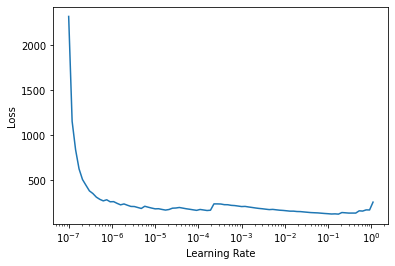

In [57]:
learn.lr_find()

In [58]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_crf_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,149.831329,110.851990,0.252063,03:21
1,120.070366,62.507153,0.625379,04:05
2,83.046822,46.854389,0.648202,04:14
3,62.531319,42.626644,0.698233,04:36
4,50.549274,45.847187,0.723074,04:11
5,43.849651,39.024208,0.742153,04:16
6,36.382923,40.039272,0.759703,04:18
7,32.807117,40.211197,0.767431,04:25
8,31.406328,41.065979,0.763717,04:22
9,29.223454,42.091816,0.762038,04:20


Better model found at epoch 0 with f1_score value: 0.25206293624567744.


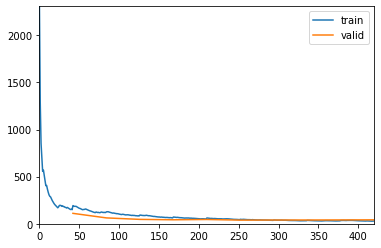

Better model found at epoch 1 with f1_score value: 0.6253790011711321.
Better model found at epoch 2 with f1_score value: 0.6482016650865791.
Better model found at epoch 3 with f1_score value: 0.6982331387013132.
Better model found at epoch 4 with f1_score value: 0.7230737998211398.
Better model found at epoch 5 with f1_score value: 0.7421530750538744.
Better model found at epoch 6 with f1_score value: 0.7597028083162276.
Better model found at epoch 7 with f1_score value: 0.7674312612526871.


In [59]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [60]:
model = BiLSTMCRF(hidden_dim=256)

In [61]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=1.0964781722577754e-06)

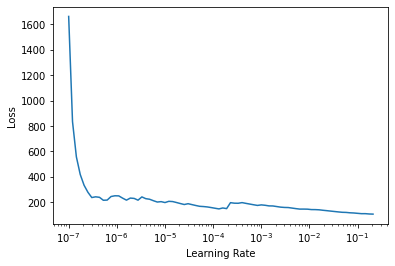

In [62]:
learn.lr_find()

In [63]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_crf_256'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,134.512543,85.542542,0.469704,03:57
1,90.833908,43.927441,0.711424,04:21
2,68.291672,37.831848,0.726812,04:21
3,50.566601,61.461323,0.725289,04:24
4,46.711521,38.017696,0.758176,04:14
5,36.325333,36.228466,0.768638,04:11
6,31.310980,37.981602,0.775473,04:17
7,26.603998,36.238197,0.771468,04:16
8,25.199459,39.141491,0.772091,04:27
9,23.588184,40.136883,0.771817,04:06


Better model found at epoch 0 with f1_score value: 0.4697038971861604.


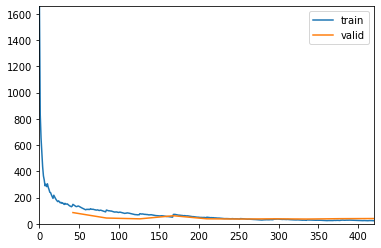

Better model found at epoch 1 with f1_score value: 0.7114241621453211.
Better model found at epoch 2 with f1_score value: 0.7268115678137878.
Better model found at epoch 4 with f1_score value: 0.7581757623316677.
Better model found at epoch 5 with f1_score value: 0.7686379328546765.
Better model found at epoch 6 with f1_score value: 0.7754725050181825.


In [64]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [32]:
model = BiLSTMCRF(hidden_dim=256)

In [33]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [34]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_crf_256_moreEpochs'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,148.483292,107.934662,0.249554,01:18
1,113.375999,65.834961,0.632667,00:39
2,85.555763,47.323429,0.707314,00:32
3,64.824997,39.873817,0.714194,00:33
4,55.123444,60.563896,0.735922,00:35
5,51.034119,39.222775,0.764405,00:35
6,38.808064,37.982185,0.762191,00:32
7,32.379013,44.539783,0.779332,00:32
8,33.746864,40.030781,0.771069,00:32
9,27.747232,44.690769,0.780427,00:32


Better model found at epoch 0 with f1_score value: 0.24955367317017232.


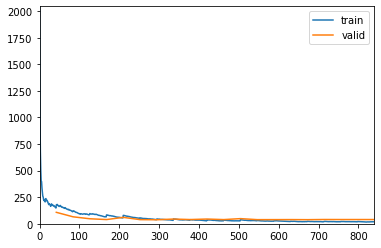

Better model found at epoch 1 with f1_score value: 0.6326665216960574.
Better model found at epoch 2 with f1_score value: 0.7073140405844507.
Better model found at epoch 3 with f1_score value: 0.7141935985685803.
Better model found at epoch 4 with f1_score value: 0.7359222488695553.
Better model found at epoch 5 with f1_score value: 0.7644049091916504.
Better model found at epoch 7 with f1_score value: 0.7793319164288345.
Better model found at epoch 9 with f1_score value: 0.780427447140808.
Better model found at epoch 11 with f1_score value: 0.7804287114968506.


In [35]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [36]:
learn.load("best_lstm_crf_256_moreEpochs")

In [37]:
def evaluate_crf(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    crf_preds =[]
    crf_targs=[]
    for pred, targ in zip(preds, targets):
        pred = pred.unsqueeze(0)
        targ = targ.unsqueeze(0)
        mask = tensor(targ.data != OUT_DIM)
        mask=mask.view(pred.shape[:2])
        pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
        pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
        targ = targ[mask].view(-1)
        crf_preds.append(pred)
        crf_targs.append(targ)
    crf_preds = torch.cat(crf_preds)
    crf_targs = torch.cat(crf_targs)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab, digits=4))
    crf_preds = torch.remainder(crf_preds, 6)
    crf_targs = torch.remainder(crf_targs, 6)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab[:6], digits=4))
    

In [38]:
evaluate_crf(learn, dls.valid)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.8927    0.7861    0.8360       201
B-agravo_em_recurso_extraordinario     0.7067    0.2236    0.3397       237
     B-despacho_de_admissibilidade     0.7226    0.6735    0.6972       147
                          B-outros     0.9811    0.2492    0.3974     25898
                   B-peticao_do_RE     0.7117    0.2423    0.3616       326
                        B-sentenca     0.8182    0.5704    0.6722       284
          I-acordao_de_2_instancia     0.5714    0.5714    0.5714        98
I-agravo_em_recurso_extraordinario     0.6033    0.5345    0.5668      1912
     I-despacho_de_admissibilidade     0.5000    0.0556    0.1000        36
                          I-outros     0.7191    0.9671    0.8249     58206
                   I-peticao_do_RE     0.7440    0.7638    0.7538      6038
                        I-sentenca     0.8646    0.7559    0.8066      1352

          

In [72]:
test_dl = torch.load("./data/test_dl_sequence.pth")

In [39]:
evaluate_crf(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9213    0.8241    0.8700       199
B-agravo_em_recurso_extraordinario     0.5965    0.1596    0.2519       213
     B-despacho_de_admissibilidade     0.6544    0.6054    0.6290       147
                          B-outros     0.9719    0.2459    0.3925     25744
                   B-peticao_do_RE     0.6699    0.2212    0.3325       312
                        B-sentenca     0.8434    0.6302    0.7214       265
          I-acordao_de_2_instancia     0.5769    0.8108    0.6742        74
I-agravo_em_recurso_extraordinario     0.5751    0.5295    0.5513      1628
     I-despacho_de_admissibilidade     0.1250    0.0196    0.0339        51
                          I-outros     0.7252    0.9707    0.8302     59664
                   I-peticao_do_RE     0.7725    0.7423    0.7571      6019
                        I-sentenca     0.8517    0.7645    0.8057      1210

          